In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_train.csv
/kaggle/input/atis-airlinetravelinformationsystem/atis_intents.csv
/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_test.csv


In [2]:
import numpy as np
import pandas as pd
import os
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score, confusion_matrix, accuracy_score
import seaborn as sns

nltk.download('punkt')


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Путь к файлу CSV
data_path = "/kaggle/input/atis-airlinetravelinformationsystem/atis_intents.csv"

# Чтение данных из CSV-файла
data = pd.read_csv(data_path)
data = data.rename(columns={'atis_flight': 'intent', ' i want to fly from boston at 838 am and arrive in denver at 1110 in the morning': 'text'})
lost_intent = {'intent': 'atis_flight', 'text': 'i want to fly from boston at 838 am and arrive in denver at 1110 in the morning'}
data = pd.concat([data, pd.DataFrame([lost_intent])], ignore_index=True)

# Find classes with only one sample
class_counts = data['intent'].value_counts()
single_sample_classes = class_counts[class_counts == 1].index.tolist()

# Separate single sample classes
single_sample_data = data[data['intent'].isin(single_sample_classes)]
multiple_sample_data = data[~data['intent'].isin(single_sample_classes)]

In [4]:
# Perform stratified split on multiple sample data
train_multiple, test_multiple = train_test_split(multiple_sample_data, test_size=0.2, random_state=42, stratify=multiple_sample_data['intent'])

# Add single sample data to both train and test sets to ensure all classes are present
train = pd.concat([train_multiple, single_sample_data]).reset_index(drop=True)
test = pd.concat([test_multiple, single_sample_data]).reset_index(drop=True)

# Ensure no duplicates in train and test sets
train = train.drop_duplicates().reset_index(drop=True)
test = test.drop_duplicates().reset_index(drop=True)

In [6]:
# Check for missing classes and ensure all classes are present
train_classes = set(train['intent'])
test_classes = set(test['intent'])
all_classes = set(data['intent'])

# Find missing classes in train and test sets
missing_train_classes = all_classes - train_classes
missing_test_classes = all_classes - test_classes

# Add missing classes examples to train and test sets
if missing_train_classes:
    missing_train_data = data[data['intent'].isin(missing_train_classes)]
    train = pd.concat([train, missing_train_data])
    train = train.drop_duplicates().reset_index(drop=True)

if missing_test_classes:
    missing_test_data = data[data['intent'].isin(missing_test_classes)]
    test = pd.concat([test, missing_test_data])
    test = test.drop_duplicates().reset_index(drop=True)

# Print unique value proportions
unique_values_normalized = train['intent'].value_counts(normalize=True)
unique_values_normalized_test = test['intent'].value_counts(normalize=True)
unique_values_normalized_data = data['intent'].value_counts(normalize=True)
print(unique_values_normalized * 100, len(unique_values_normalized), len(unique_values_normalized_test),len(unique_values_normalized_data)) 

intent
atis_flight                                 73.869079
atis_airfare                                 8.621607
atis_ground_service                          5.082491
atis_airline                                 3.113358
atis_abbreviation                            2.474721
atis_aircraft                                1.676424
atis_flight_time                             1.117616
atis_quantity                                1.091006
atis_distance                                0.425758
atis_flight#atis_airfare                     0.399148
atis_ground_fare                             0.372539
atis_airport                                 0.372539
atis_city                                    0.372539
atis_capacity                                0.345929
atis_flight_no                               0.266099
atis_meal                                    0.133049
atis_restriction                             0.106440
atis_airline#atis_flight_no                  0.053220
atis_ground_service#a

In [7]:
# Label encoding
le = LabelEncoder()
le.fit(data['intent'])  # Fit on the entire data to include all possible labels
train['intent'] = le.transform(train['intent'])
test['intent'] = le.transform(test['intent'])

# TF-IDF vectorization
vectorizer = TfidfVectorizer(tokenizer=word_tokenize)
X_train = vectorizer.fit_transform(train['text']).toarray()
X_test = vectorizer.transform(test['text']).toarray()

y_train = train['intent']
y_test = test['intent']

# Reshape data to add sequence dimension
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [8]:
# Определение датасета
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Определение модели RNN
class RNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        out = self.fc(rnn_out[:, -1, :])
        return out


In [9]:
train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Инициализация модели
input_dim = X_train.shape[2]
hidden_dim = 256
output_dim = len(le.classes_)
model = RNNClassifier(input_dim, hidden_dim, output_dim)

# Настройка устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch 1/15 - Validation: 100%|██████████| 31/31 [00:00<00:00, 581.87it/s]


Epoch 1, Train Loss: 1.3338, Val Loss: 0.8269


Epoch 2/15 - Validation: 100%|██████████| 31/31 [00:00<00:00, 970.96it/s]


Epoch 2, Train Loss: 0.5894, Val Loss: 0.5380


Epoch 3/15 - Validation: 100%|██████████| 31/31 [00:00<00:00, 972.45it/s]


Epoch 3, Train Loss: 0.3627, Val Loss: 0.4024


Epoch 4/15 - Validation: 100%|██████████| 31/31 [00:00<00:00, 914.51it/s]


Epoch 4, Train Loss: 0.2481, Val Loss: 0.3287


Epoch 5/15 - Validation: 100%|██████████| 31/31 [00:00<00:00, 981.66it/s]


Epoch 5, Train Loss: 0.1786, Val Loss: 0.2805


Epoch 6/15 - Validation: 100%|██████████| 31/31 [00:00<00:00, 872.47it/s]


Epoch 6, Train Loss: 0.1313, Val Loss: 0.2481


Epoch 7/15 - Validation: 100%|██████████| 31/31 [00:00<00:00, 936.05it/s]


Epoch 7, Train Loss: 0.0971, Val Loss: 0.2314


Epoch 8/15 - Validation: 100%|██████████| 31/31 [00:00<00:00, 970.37it/s]


Epoch 8, Train Loss: 0.0744, Val Loss: 0.2154


Epoch 9/15 - Validation: 100%|██████████| 31/31 [00:00<00:00, 859.11it/s]


Epoch 9, Train Loss: 0.0586, Val Loss: 0.2047


Epoch 10/15 - Validation: 100%|██████████| 31/31 [00:00<00:00, 940.77it/s]


Epoch 10, Train Loss: 0.0474, Val Loss: 0.1972


Epoch 11/15 - Validation: 100%|██████████| 31/31 [00:00<00:00, 946.57it/s]


Epoch 11, Train Loss: 0.0388, Val Loss: 0.1975


Epoch 12/15 - Validation: 100%|██████████| 31/31 [00:00<00:00, 921.91it/s]


Epoch 12, Train Loss: 0.0319, Val Loss: 0.1876


Epoch 13/15 - Validation: 100%|██████████| 31/31 [00:00<00:00, 926.33it/s]


Epoch 13, Train Loss: 0.0267, Val Loss: 0.1873


Epoch 14/15 - Validation: 100%|██████████| 31/31 [00:00<00:00, 904.83it/s]


Epoch 14, Train Loss: 0.0225, Val Loss: 0.1839


Epoch 15/15 - Validation: 100%|██████████| 31/31 [00:00<00:00, 961.91it/s]


Epoch 15, Train Loss: 0.0192, Val Loss: 0.1845


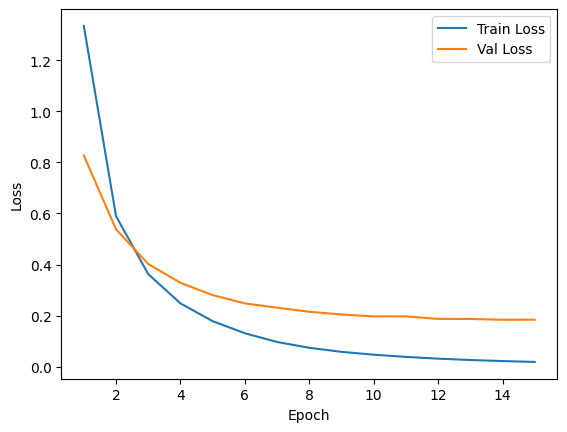

In [10]:
# Параметры обучения
n_epoches = 15

# Листы для хранения потерь на обучающей и валидационной выборках
train_losses = []
val_losses = []

for epoch in range(n_epoches):
    train_loss = 0
    val_loss = 0

    # Обучение
    model.train()
    for texts, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{n_epoches} - Training'):
        texts = texts.to(device)
        labels = labels.to(device)

        outputs = model(texts)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Валидация
    model.eval()
    with torch.no_grad():
        for texts, labels in tqdm(test_loader, desc=f'Epoch {epoch+1}/{n_epoches} - Validation'):
            texts = texts.to(device)
            labels = labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

    # Вычисление среднего значения потерь на эпоху
    train_loss /= len(train_loader)
    val_loss /= len(test_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Построение графика потерь
plt.plot(range(1, n_epoches+1), train_losses, label='Train Loss')
plt.plot(range(1, n_epoches+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [11]:
import timeit

In [12]:
# Predictions on the test set
predictions = []
true_labels = []
start_test = timeit.default_timer()
model.eval()
with torch.no_grad():
    for texts, labels in test_loader:
        texts = texts.to(device)
        labels = labels.to(device)
        
        outputs = model(texts)
        _, predicted = torch.max(outputs.data, 1)
        
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
end_test = timeit.default_timer()

# Translate predicted labels back to original intents
predicted_intents = le.inverse_transform(predictions)

# Total number of predictions
num_predictions = len(predictions)

# Average time per response
average_time_per_response = (end_test - start_test) / num_predictions

print(f'Time for testing: {end_test - start_test:.4f} seconds')
print(f'Average time per response: {average_time_per_response:.6f} seconds')

# Model evaluation
balanced_acc = balanced_accuracy_score(true_labels, predictions)
precision, recall, fscore, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')

print(f'Balanced Accuracy: {balanced_acc:.4f}')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {fscore:.4f}')


Time for testing: 0.0493 seconds
Average time per response: 0.000050 seconds
Balanced Accuracy: 0.6763
Precision: 0.9543, Recall: 0.9582, F1-Score: 0.9557


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
